## Dice-20 game

In this notebook, we use a value iteration algorithm to find the optimal policy to maximize the win in the "Dice 20 game".

The player holds a 20-faced dice (whose faces are numbered in $1,...,20$). Each turn the player can:

- take an amount of money corresponding to the upper face of the dice

- roll the dice without picking any reward

The player runs 20 turns and at round 1 the dice shows one of its faces in $1,...,20$.

In [15]:
# simple imports
import pandas as pd
import numpy as np

In [16]:
# define random seed
np.random.seed(32)

# define a class to play the game
class Game:
    def __init__(self, alpha=0.9, gamma=1, epsilon=0.05):
        self.dice = np.random.randint(1,21)
        self.t = 0
        # define Q and its last row, which will always be the current dice value
        self.Q = np.zeros((20,20,2))
        self.Q[:,19,0] = np.array([n for n in range(1, 21)])
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.rand_float = np.random.rand(20)
        self.delta_q = []
        
    def reset(self):
        self.dice = np.random.randint(1,21)
        self.t = 0
        self.rand_float = np.random.rand(20)
        
    def compute_policy(self):
        return np.argmax(self.Q, axis=2)
    
    def play_turn(self):
        # implement an epsilon-greedy policy
        # with a probability = 1-epsilon go greedy
        # else action is non-greedy (aid exploration)
        if self.rand_float[self.t] <= 1-self.epsilon:
            action = np.argmax(self.Q[self.dice-1, self.t])
        else:
            action = 1-np.argmax(self.Q[self.dice-1, self.t])
            
        # stay with the dice and take reward
        if action == 0:
            r = self.dice
            self.Q[self.dice-1, self.t, action] = r + self.gamma * self.Q[self.dice-1, self.t+1, np.argmax(self.Q[self.dice-1, self.t+1])]
        # else dice has been thrown
        else:
            r = 0
            self.dice = np.random.randint(1,21)
            self.Q[self.dice-1, self.t, action] = r + self.gamma * np.mean(np.max(self.Q, axis=2)[:,self.t+1])          
        self.t += 1
    
    def play_game(self, repeat=200):
        start_Q = self.Q.copy()
        for i in range(repeat):
            for j in range(0, 20-1):
                game.play_turn()
            game.reset()
        end_Q = self.Q
        self.delta_q.append(np.sqrt(np.sum((end_Q-start_Q)**2)))

In [3]:
# define a game object
game = Game()

In [4]:
# play a hundred times 100 games to update the policy
for i in range(100):
    game.play_game()
game.reset()

In [20]:
# import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

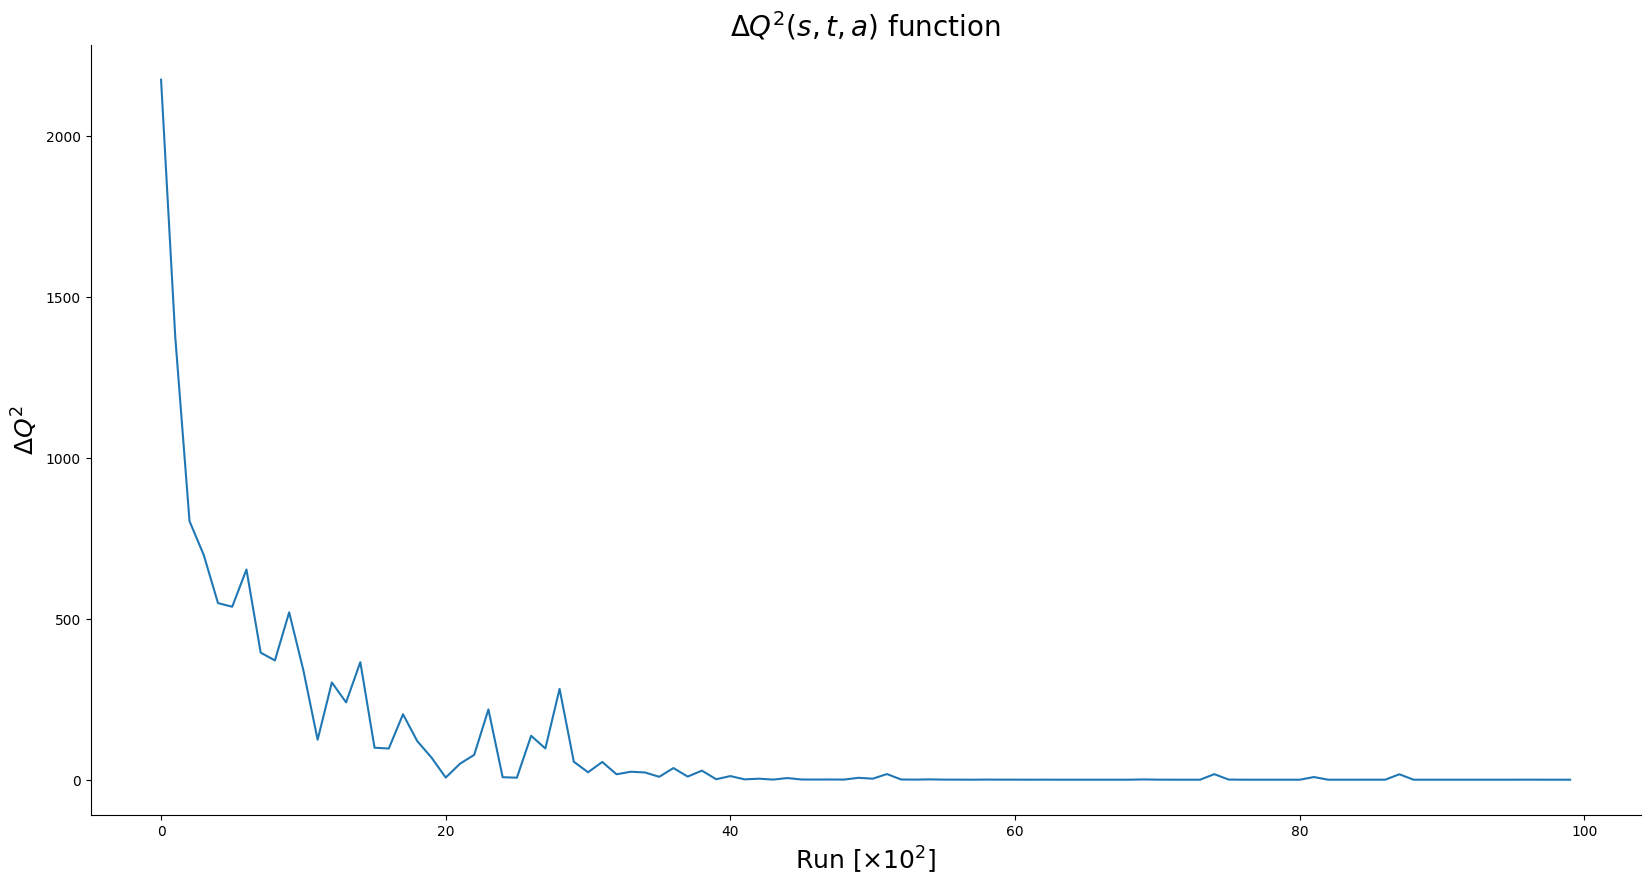

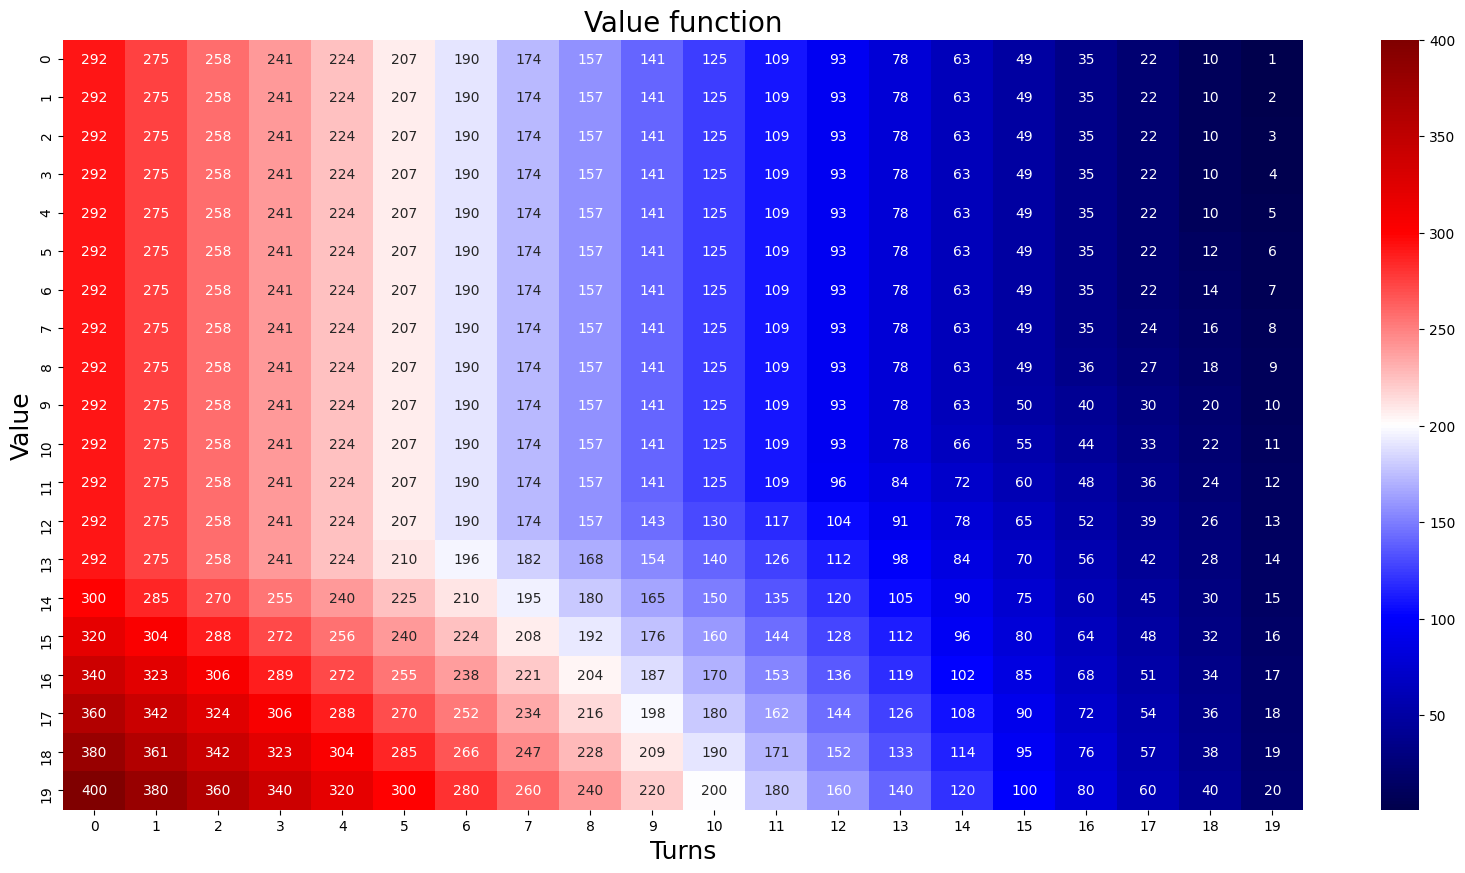

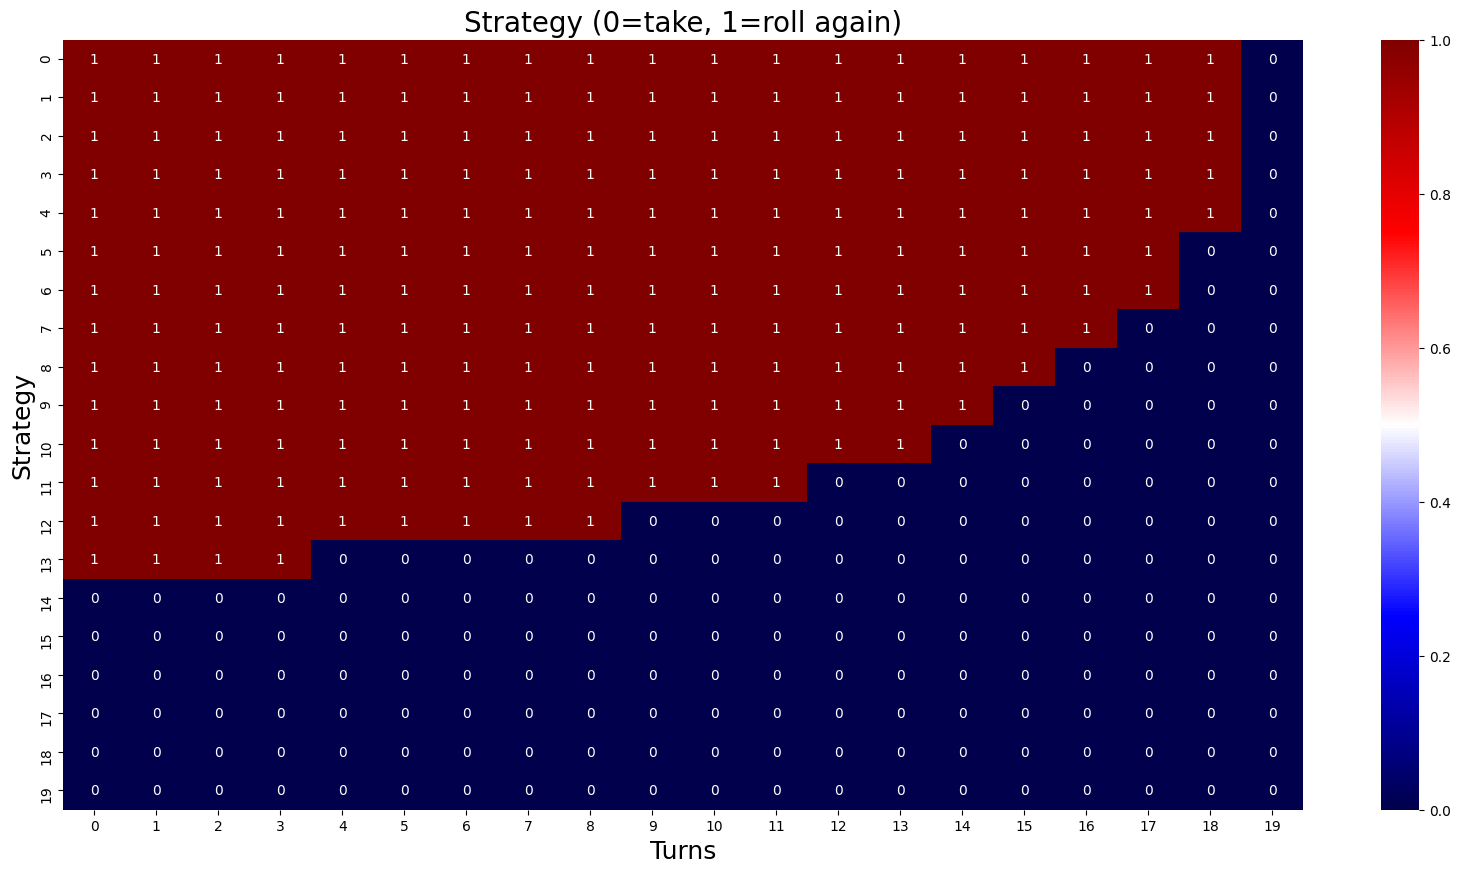

In [22]:
# plot functions
fig, ax = plt.subplots(figsize=(20,10))
plt.title(r'$\Delta Q^2(s,t,a)$ function', fontsize=20)
plt.plot(game.delta_q)
plt.ylabel(r'$\Delta Q^2$', fontsize=18)
plt.xlabel(r'Run [$\times 10^2$]', fontsize=18)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.plot()

# plot 2 -> value function
fig, ax = plt.subplots(figsize=(20,10))
plt.title(r'Value function', fontsize=20)
sns.heatmap(np.round(np.max(game.Q, axis=2), 0), annot=True, cbar=True, fmt='g', cmap='seismic')
plt.xlabel(r'Turns', fontsize=18)
plt.ylabel(r'Value', fontsize=18)
plt.show()

# plot 3 -> strategy
fig, ax = plt.subplots(figsize=(20,10))
plt.title(r'Strategy (0=take, 1=roll again)', fontsize=20)
sns.heatmap(np.argmax(game.Q, axis=2), annot=True, cbar=True, fmt='g', cmap='seismic')
plt.xlabel(r'Turns', fontsize=18)
plt.ylabel(r'Strategy', fontsize=18)
plt.show()